<a href="https://colab.research.google.com/github/Chansikan/Python-tutorial/blob/master/SHAP_meningioma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [ ]:
!pip install shap

In [2]:
# import modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import shap

import os
import warnings
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RepeatedStratifiedKFold

from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.svm import LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import roc_auc_score

# set working directory
wd = '/content/drive/My Drive/ResearchProjects/[2020Oct-]SHAP/'

In [68]:
df = pd.read_csv(os.path.join(wd, 'radiomics_binw32.csv'))
X = df.iloc[:, 5:]
y = df['label']

feature_excluded = ['T2_glszm_LargeAreaLowGrayLevelEmphasis', 
                    'T2_glrlm_LongRunLowGrayLevelEmphasis',
                    'T1C_glszm_LargeAreaLowGrayLevelEmphasis',
                    'T1C_firstorder_Variance', 
                    'T2_glcm_ClusterProminence']
feature_excluded.extend(list(X.columns[X.columns.str.startswith('T2_shape')]))

feature_selected = [col for col in list(X.columns) if col not in feature_excluded]

X = X.loc[:, feature_selected]
#X.columns

## Meningioma: feature selection methods

### Robust feature selection

In [81]:
# Function for feature selection: separate version

def select_features(X, y, n_bs=100, cut_off=0.85, model='svc'):
  print('Feature selection by boot-strapping', end=': ')

  for i, rs in enumerate(range(n_bs)):
    print(i+1, end='/')
  
    np.random.seed(rs)
    idx = np.random.choice(list(range(len(X))), len(X), replace=True)
    X_resampled = X.iloc[idx, :]
    y_resampled = y[idx]
  
    if np.sum(y_resampled) <= 1:
      continue

    # model-based feature selection
    if model == 'svc':
      selector = SelectFromModel(LinearSVC(max_iter=10000, dual=False, random_state=rs))
    elif model == 'rf':
      selector = SelectFromModel(RandomForestClassifier(random_state=rs))
    elif model == 'lr':
      selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear',
                                            max_iter=10000, dual=False, random_state=rs))
    
    f = selector.fit(X_resampled, y_resampled).get_support().astype('int8')
    col = pd.DataFrame({'frequency': f}, index=X_resampled.columns)
  
    if i == 0:
      result_df = col
    else:
      result_df = pd.concat([result_df, col], axis = 1, sort=False)

  print('')

  freq = result_df.mean(axis=1)

  return list(freq.index[freq>cut_off])

In [78]:
# Function for feature selection: together version

def select_features(X, y, n_bs=100, cut_off=0.85, model='lr'):
  print('Feature selection by boot-strapping', end=': ')

  for i, rs in enumerate(range(n_bs)):
    print(i+1, end='/')
  
    np.random.seed(rs)
    idx = np.random.choice(list(range(len(X))), len(X), replace=True)
    X_resampled = X.iloc[idx, :]
    y_resampled = y[idx]
  
    if np.sum(y_resampled) <= 1:
      continue

    # model-based feature selection
    svc = SelectFromModel(LinearSVC(max_iter=10000, dual=False, random_state=rs))
    rf = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=rs))
    lr = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear',
                                            max_iter=10000, dual=False, random_state=rs))
    
    cnt = 0
    for name, model in zip(['SVC', 'RF', 'LASSO'], [svc, rf, lr]):
      f = model.fit(X_resampled, y_resampled).get_support().astype('int8')
      col = pd.DataFrame({name: f}, index=X_resampled.columns)
      if i == 0:
        col = pd.DataFrame({'model': name, 'frequency': f}, index=X_resampled.columns)
      else:
        col = pd.DataFrame({'frequency': f}, index=X_resampled.columns)
          
      if cnt == 0:
        rslt = col
      else: 
        rslt = pd.concat([rslt, col], axis = 0, sort=False) 
      cnt += 1

    if i == 0:
      result_df = rslt
    else:
      result_df = pd.concat([result_df, rslt], axis = 1, sort=False)

  feat_list = []
  for name, model in zip(['SVC', 'RF', 'LASSO'], [svc, rf, lr]):
    a = result_df[result_df.model==name]
    frq = a.iloc[:, 1:].mean(axis=1)
    feat_list.extend(list(frq.index[frq>cut_off]))

  print('')
  return list(set(feat_list))

In [82]:
##### Robust feature selection #####
scaler = RobustScaler()

n_bs = 100
n_trial = 5
p_grid = {"C": [0.0001, 0.0005, 0.001, 0.005, 
                0.01, 0.05, 0.1, 0.5, 
                1, 2, 5, 10]}

result_dict = {}

for nt in range(n_trial):
  print('Trial No.:', nt+1)
  kf = KFold(n_splits=5, shuffle=True, random_state=nt)

  auc_results =[]
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index].values, y[test_index].values

    # scaling
    scaler.fit(X_train, y_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                columns=X_train.columns)

    # select features
    selected_features = select_features(X_train_scaled, y_train, 
                                        n_bs=n_bs, model='rf')
    X_train_selected = X_train_scaled.loc[:, selected_features]
    X_test_selected = X_test_scaled.loc[:, selected_features]

    # Grid-search CV
    search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=p_grid,
                          scoring='roc_auc', cv=5)
    search.fit(X_train_selected, y_train)

    # prediction
    y_pred = search.predict_proba(X_test_selected)
    auc = roc_auc_score(y_test, y_pred[:,1])
    auc_results.append(auc)
  
  result_dict[nt] = auc_results

result_df = pd.DataFrame.from_dict(result_dict)

Trial No.: 1
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Trial No.: 2
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Trial No.: 3
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Trial No.: 4
Feature selection by boot-strapping: 1/2/3/4/5/6/7/8/9/10/
Feat

In [83]:
# result_df = pd.read_csv(os.path.join(wd, 'CV_RobustFeatSelection.csv'))

min_auc = round(np.array(result_df).min(), 3)
max_auc = round(np.array(result_df).max(), 3)
mean_auc = round(np.array(result_df).mean(), 3)
std_auc = round(np.array(result_df).std(), 3)
rsd = round(std_auc / mean_auc * 100, 3)

print(mean_auc, min_auc, max_auc, std_auc, rsd)

0.803 0.703 0.917 0.056 6.974


### Conventional feature selection

In [36]:
def fs_and_predict(estimator, X_train, y_train, X_test, y_test, prob=True):
  # feature selection
  selector = SelectFromModel(estimator).fit(X_train, y_train)
  X_train_selected = selector.transform(X_train)
  X_test_selected = selector.transform(X_test)

  # optimize a model via grid-search CV
  search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=p_grid,
                        scoring='roc_auc', cv=5)
  search.fit(X_train_selected, y_train)

  # prediction
  if prob:
    y_pred = search.predict_proba(X_test_selected)
    auc = roc_auc_score(y_test, y_pred[:,1])
  else:
    y_pred = search.decision_function(X_test_selected)
    auc = roc_auc_score(y_test, y_pred)
  
  return auc

In [38]:
##### Conventional feature selection #####
scaler = RobustScaler()

n_trial = 10
C_list = list(np.arange(0.01, 0.1, 0.01)) + \
         list(np.arange(0.1, 1, 0.1)) + \
         list(np.arange(1, 2, 0.5)) + \
         list(np.arange(2, 20, 1))
p_grid = {'C': C_list}

result_dict = {'SVC':[], 'RF':[], 'LASSO':[]}

for i, rs in enumerate(range(n_trial)):
  print('Trial No.', i+1)
  kf = KFold(n_splits=5, shuffle=True, random_state=rs)
  
  cnt = 1
  print('     Fold No.', end=': ')
  for train_index, test_index in kf.split(X):
    if cnt == 5:
      print(cnt, end='\n')
    else:
      print(cnt, end='/')
    cnt += 1

    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # scaling
    scaler.fit(X_train, y_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                columns=X_train.columns)
    
    # feature selction and prediction
    auc_svc = fs_and_predict(LinearSVC(max_iter=10000, dual=False, random_state=rs), 
                             X_train_scaled, y_train, X_test_scaled, y_test, prob=False)
    
    auc_rf = fs_and_predict(RandomForestClassifier(random_state=rs),
                            X_train_scaled, y_train, X_test_scaled, y_test, prob=True)
    
    auc_lr = fs_and_predict(LogisticRegression(penalty="l1", solver='liblinear',
                                            max_iter=10000, dual=False, random_state=rs),
                            X_train_scaled, y_train, X_test_scaled, y_test, prob=True)
    
    result_dict['SVC'].append(auc_svc)
    result_dict['RF'].append(auc_rf)
    result_dict['LASSO'].append(auc_lr)
  
  pd.DataFrame.from_dict(result_dict).to_csv(os.path.join(wd, 'CV_ConvFeatSelection.csv'))

Trial No. 1
     Fold No.: 1/2/3/4/5
Trial No. 2
     Fold No.: 1/2/3/4/5
Trial No. 3
     Fold No.: 1/2/3/4/5
Trial No. 4
     Fold No.: 1/2/3/4/5
Trial No. 5
     Fold No.: 1/2/3/4/5
Trial No. 6
     Fold No.: 1/2/3/4/5
Trial No. 7
     Fold No.: 1/2/3/4/5
Trial No. 8
     Fold No.: 1/2/3/4/5
Trial No. 9
     Fold No.: 1/2/3/4/5
Trial No. 10
     Fold No.: 1/2/3/4/5
Trial No. 11
     Fold No.: 1/2/3/4/5
Trial No. 12
     Fold No.: 1/

KeyboardInterrupt: ignored

In [39]:
def describe_result(dat):
  min_auc = round(np.array(dat).min(), 3)
  max_auc = round(np.array(dat).max(), 3)
  mean_auc = round(np.array(dat).mean(), 3)
  std_auc = round(np.array(dat).std(), 3)
  rsd = round(std_auc / mean_auc * 100, 3)

  return mean_auc, min_auc, max_auc, std_auc, rsd

print(describe_result(result_dict['LASSO']))
print(describe_result(result_dict['RF']))
print(describe_result(result_dict['SVC']))

(0.728, 0.598, 0.86, 0.061, 8.379)
(0.779, 0.622, 0.882, 0.058, 7.445)
(0.715, 0.497, 0.887, 0.078, 10.909)


In [ ]:
##### Logistic regression #####
lr = LogisticRegression(max_iter=1000)
lr.fit(X_selected_sev, y_sev)

shap_lr_sev = shap.LinearExplainer(lr, X_selected_sev).shap_values(X_selected_sev)
shap.summary_plot(shap_lr_sev, X_selected_sev, plot_type="violin")

shap_lr_asan = shap.LinearExplainer(lr, X_selected_asan).shap_values(X_selected_asan)
shap.summary_plot(shap_lr_asan, X_selected_asan, plot_type="violin")

In [ ]:
##### Random Forest #####
rf = RandomForestClassifier()
rf.fit(X_selected, y)

shap_rf = shap.TreeExplainer(rf).shap_values(X_selected)

shap.summary_plot(shap_rf[1], X_selected, plot_type="violin", max_display=28)

In [ ]:
##### Linear SVC #####
svc = LinearSVC()
svc.fit(X_selected, y)

explainer = shap.KernelExplainer(svc.decision_function, shap.sample(X_selected, 100))
shap_svc = explainer.shap_values(X_selected)

In [ ]:
shap.summary_plot(shap_svc, X_selected, plot_type="violin", max_display=28)

In [ ]:
### aggregation
shap_mean = (shap_svc + shap_lr + shap_rf[1])/3
shap.summary_plot(shap_mean, X_selected, plot_type="violin", max_display=28)


## Compared three methods

In [43]:
df = pd.read_csv(os.path.join(wd, 'radiomics_binw32.csv'))
frq = pd.read_csv(os.path.join(wd, 'Frequencies_meningioma.csv'))
X = df.iloc[:, 5:]
y = df['label']

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X, y), columns=X.columns)

f_set_1 = [
# favoring low grade                 
'T1C_shape_Flatness', 'T1C_shape_Sphericity', 'T1C_glszm_SmallAreaEmphasis',
'T1C_glszm_SmallAreaHighGrayLevelEmphasis', 'T1C_glrlm_RunLengthNonUniformity',
'T1C_ngtdm_Strength',
# favoring high grade
'T1C_shape_SurfaceArea', 'T1C_shape_Maximum3DDiameter', 'T2_glcm_ClusterShade'
]

f_set_2 = [
# favoring low grade                 
'T1C_shape_Flatness', 'T1C_shape_Sphericity', 'T1C_glszm_SmallAreaEmphasis',
'T1C_glszm_SmallAreaHighGrayLevelEmphasis',
# favoring high grade
'T1C_shape_SurfaceArea', 'T1C_shape_Maximum3DDiameter',
]

f_set = f_set_2
# 1) Conventional method
estimator= LogisticRegression(max_iter=1000, random_state=2)      
selector = SelectFromModel(estimator).fit(X_scaled, y)

X_conv = selector.transform(X_scaled)

# 2) Frequency in order 
X_frq = X_scaled.loc[:, list(frq.feature[:len(f_set)])]

# 3) SHAP
X_shap = X_scaled.loc[:, f_set]

print('Shape of X_conv, X_frq, and X_shap:', 
      X_conv.shape, X_frq.shape, X_shap.shape)


Shape of X_conv, X_frq, and X_shap: (258, 75) (258, 6) (258, 6)


In [46]:
p_grid = {"C": [0.0001, 0.0005, 0.001, 0.005, 
                0.01, 0.05, 0.1, 0.5, 
                1, 2, 5, 10]}
n_rep = 1000
method = 'frq'


result_dict = {}
for i, method in enumerate(['conv', 'frq', 'shap']):
  auc_results = []
  
  for rs in tqdm(range(n_rep)):
    kf = KFold(n_splits=5, shuffle=True, random_state=rs)
    for train_index, test_index in kf.split(X_scaled):
      X_train, X_test = X_scaled.loc[train_index, :], X_scaled.loc[test_index, :]
      y_train, y_test = y[train_index], y[test_index]

      # feature selection
      if method == 'conv':
        estimator= LogisticRegression(max_iter=1000, random_state=rs)      
        selector = SelectFromModel(estimator).fit(X_train, y_train)
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)
      if method == 'frq':
        X_train_selected = X_train.loc[:, list(frq.feature[:len(f_set)])]
        X_test_selected = X_test.loc[:, list(frq.feature[:len(f_set)])]
      if method == 'shap':
        X_train_selected = X_train.loc[:, f_set]
        X_test_selected = X_test.loc[:, f_set]

      # optimize a model via grid-search CV
      search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=p_grid,
                            scoring='roc_auc', cv=5)
      search.fit(X_train_selected, y_train)

      # prediction
      y_pred = search.predict_proba(X_test_selected)
      auc = roc_auc_score(y_test, y_pred[:,1])
      auc_results.append(auc)

  mean_auc = np.mean(auc_results)
  std_auc = np.std(auc_results)
  min_auc = np.min(auc_results)
  max_auc = np.max(auc_results)

  row = pd.DataFrame({'Mean': mean_auc, 'SD': std_auc,
                      'Min': min_auc, 'Max': max_auc}, index=[method])
  
  if i == 0:
    result_df = row
  else:
    result_df = pd.concat([result_df, row], axis =0)

 41%|████▏     | 414/1000 [45:21<1:05:15,  6.68s/it]

KeyboardInterrupt: ignored

In [45]:
result_df

,Mean,SD,Min,Max
conv,0.730836,0.082116,0.579832,0.874603
frq,0.795294,0.055257,0.711111,0.880383
shap,0.820893,0.051356,0.722727,0.917065


In [154]:
0.082116 / 0.730836 * 100

11.235899709373921

In [38]:
row

,Mean,SD,Min,Max
conv,0.730836,0.082116,0.579832,0.874603


In [ ]:

estimator= LogisticRegression(max_iter=1000, random_state=rs)      
selector = SelectFromModel(estimator).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_selected, y_train)

In [21]:
# Number of random trials
NUM_TRIALS = 1

# Set up possible values of parameters to optimize over
p_grid = {"C": [0.0001, 0.0005, 0.001, 0.005, 
                0.01, 0.05, 0.1, 0.5, 
                1, 2, 5, 10]}
clf = LogisticRegression(max_iter=1000)         
# Arrays to store scores


# Loop for each trial
result_dict = {}
for name, dataset in zip(['conv', 'frq', 'shap'], [X_conv, X_frq, X_shap]):
  nested_auc = np.zeros(NUM_TRIALS)
  nested_sd = np.zeros(NUM_TRIALS)

  for i in range(NUM_TRIALS):

      inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
      outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

      # Nested CV with parameter optimization
      nested_score = cross_val_score(clf, X=dataset, y=y, cv=outer_cv, 
                                     scoring='roc_auc')
      nested_auc[i] = nested_score.mean()
      nested_sd[i] = nested_score.std()
  result_dict[name] = [nested_auc, nested_sd]


In [23]:
def get_rsd(dat):
  return round(dat[1].std() / dat[0].mean() * 100, 3)

print('Conventional:', result_dict['conv'][0].mean(), 
      get_rsd(result_dict['conv']))
print('Frequency:', result_dict['frq'][0].mean(), 
      get_rsd(result_dict['frq']))
print('SHAP:', result_dict['shap'][0].mean(), 
      get_rsd(result_dict['shap']))

Conventional: 0.8253417250361261 2.329
Frequency: 0.808354593839074 2.082
SHAP: 0.813600357048518 2.209



Sphericity, flatness
T1C
GLSZM
Small area emphasis
Small area high gray level emphasis
GLRLM
Run Length Non-uniformity
NGTDM
Strength

•Shape
•Surface area, maximum 3D diameter
•T2
•GLCM
•Cluster shade

## Previously coded

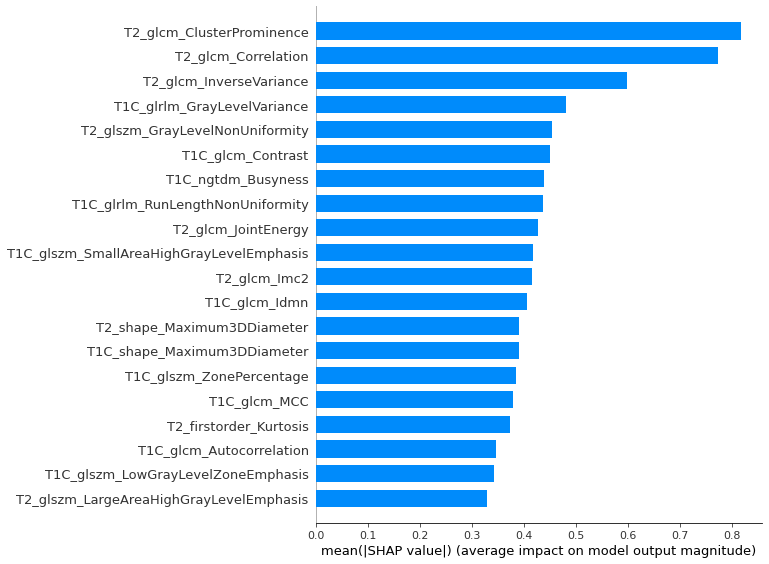

In [ ]:
# univariate 
df = pd.read_csv(os.path.join(wd, 'radiomics_binw32.csv'))

result_dict = {}
for i in range(5, len(df.columns)):

  col = df.iloc[:, i]
  col_name = col.name

  q75, q25 = np.percentile(col, [75 ,25])

  # outliers: any data point more than 1.5 interquartile ranges 
  #          below the first quartile or above the third quartile
  low_idx = col < np.median(col) - (q75-q25) * 1.5
  high_idx = col > np.median(col) + (q75-q25) * 1.5

  idx = col.loc[~(low_idx.values | high_idx.values)].index

  X_selected = df.iloc[idx, i]
  y_selected = df.iloc[idx, 1]

  model = LogisticRegression()
  model.fit(np.array(X_selected).reshape(-1, 1), y_selected)
  shap_values = shap.LinearExplainer(model, X_selected).shap_values(X_selected)

  mean_shap = np.mean(np.abs(shap_values))

  result_dict[col_name] = mean_shap

result_col = pd.DataFrame.from_dict(result_dict, orient='index')
result_col.columns = ['SHAP_value']

result_col.sort_values(by='SHAP_value', ascending=False, inplace=True)

# multivariable
df = pd.read_csv(os.path.join(wd, 'radiomics_binw32.csv'))

#SHAP_uni_LR = pd.read_csv(os.path.join(wd, 'SHAP_uni_LR.csv'), index_col=0)
#SHAP_uni_LR.loc[SHAP_uni_LR.SHAP_value > 0.5, :]

feature_excluded = ['T2_glszm_LargeAreaLowGrayLevelEmphasis', 
                     'T2_glrlm_LongRunLowGrayLevelEmphasis',
                     'T1C_glszm_LargeAreaLowGrayLevelEmphasis']
row_excluded = [np.argmax(df.T2_glcm_ClusterProminence)]

X_selected = df.iloc[:, 5:]
row_selected = [row for row in X_selected.index if row not in row_excluded]
feature_selected = [col for col in X_selected.columns if col not in feature_excluded]
X_selected = X_selected.loc[row_selected, feature_selected]
y_selected = df.loc[row_selected, 'label']

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected, y_selected), 
                        columns=X_selected.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y_selected)

shap_values = shap.LinearExplainer(model, X_scaled).shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, plot_type="bar")

#print(np.mean(np.abs(shap_values)))
